In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import time
from sklearn.decomposition import PCA

## 1. Load Data

In [107]:
data=pd.read_csv("NY property data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070994 entries, 0 to 1070993
Data columns (total 32 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   RECORD    1070994 non-null  int64  
 1   BBLE      1070994 non-null  object 
 2   B         1070994 non-null  int64  
 3   BLOCK     1070994 non-null  int64  
 4   LOT       1070994 non-null  int64  
 5   EASEMENT  4636 non-null     object 
 6   OWNER     1039249 non-null  object 
 7   BLDGCL    1070994 non-null  object 
 8   TAXCLASS  1070994 non-null  object 
 9   LTFRONT   1070994 non-null  int64  
 10  LTDEPTH   1070994 non-null  int64  
 11  EXT       354305 non-null   object 
 12  STORIES   1014730 non-null  float64
 13  FULLVAL   1070994 non-null  float64
 14  AVLAND    1070994 non-null  float64
 15  AVTOT     1070994 non-null  float64
 16  EXLAND    1070994 non-null  float64
 17  EXTOT     1070994 non-null  float64
 18  EXCD1     638488 non-null   float64
 19  STADDR    1070318 non

## 2. Data Cleaning

### 2.1 Remove properties owned by city, state, or federal governments

In [4]:
# Remove properties owned by city, state, or federal governments
remove_list=['PARKCHESTER PRESERVAT',
            'PARKS AND RECREATION',
            'DCAS',
            'HOUSING PRESERVATION',
            'CITY OF NEW YORK',
            'DEPT OF ENVIRONMENTAL',
            'BOARD OF EDUCATION',
            'NEW YORK CITY HOUSING',
            'CNY/NYCTA',
            'NYC HOUSING PARTNERSH',
            'DEPARTMENT OF BUSINES',
            'DEPT OF TRANSPORTATIO',
            'MTA/LIRR',
            'PARCKHESTER PRESERVAT',
            'MH RESIDENTIAL 1, LLC',
            'LINCOLN PLAZA ASSOCIA',
            'UNITED STATES OF AMER',
            'U S GOVERNMENT OWNRD',
            'THE CITY OF NEW YORK',
            'NYS URBAN DEVELOPMENT',
            'NYS DEPT OF ENVIRONME',
            'CULTURAL AFFAIRS',
            'DEPT OF GENERAL SERVI',
            "DEPT RE-CITY OF NY"]
property_data=data[~data['OWNER'].isin(remove_list)].copy().reset_index()

### 2.2 Filling N/A

#### 2.2.1 ZIP

In [5]:
missing_zips=property_data.index[property_data["ZIP"].isnull()].tolist()
len(missing_zips)

21772

In [6]:
# fill with surrounding zips if the zips before and after the row are the same
for i in missing_zips:
    if(property_data.loc[i+1,'ZIP']==property_data.loc[i-1,'ZIP']):
        property_data.loc[i,'ZIP']=property_data.loc[i-1,'ZIP']
missing_zips=property_data.index[pd.isnull(property_data["ZIP"])].tolist()
len(missing_zips)

10245

In [7]:
# fill with preceding ZIP
for i in missing_zips:
    property_data.loc[i,'ZIP']=property_data.loc[i-1,'ZIP']
missing_zips=property_data.index[pd.isnull(property_data["ZIP"])].tolist()
len(missing_zips)

0

#### 2.2.2 FULLVAL, AVLAND, AVTOT

In [8]:
# mean of FULLVAL by TAXCLASS
property_data["FULLVAL"]=property_data["FULLVAL"].replace('NaN',0)
temp=property_data[property_data["FULLVAL"]!=0]
mean_fullval=temp.groupby("TAXCLASS")["FULLVAL"].mean()
print(mean_fullval)

TAXCLASS
1     5.700059e+05
1A    3.352942e+05
1B    3.738399e+05
1C    7.615359e+05
1D    2.233614e+07
2     8.005832e+05
2A    8.639066e+05
2B    1.254525e+06
2C    7.723493e+05
3     8.510005e+04
4     2.772747e+06
Name: FULLVAL, dtype: float64


In [9]:
# mean of AVLAND by TAXCLASS
property_data["AVLAND"]=property_data["AVLAND"].replace('NaN',0)
temp_avland=property_data[property_data["AVLAND"]!=0]
mean_avland=temp.groupby("TAXCLASS")["AVLAND"].mean()

In [10]:
# mean of AVTOT by TAXCLASS
property_data["AVTOT"]=property_data["AVTOT"].replace('NaN',0)
temp_avtot=property_data[property_data["AVTOT"]!=0]
mean_avtot=temp.groupby("TAXCLASS")["AVTOT"].mean()

In [11]:
# sustitute 0 with averages by TAXCLASS
%time
for index in mean_fullval.index:
    property_data.loc[(property_data["FULLVAL"]==0)&(property_data["TAXCLASS"]==index),"FULLVAL"]=mean_fullval[index]
    property_data.loc[(property_data["AVLAND"]==0)&(property_data["TAXCLASS"]==index),"AVLAND"]=mean_avland[index]
    property_data.loc[(property_data["AVTOT"]==0)&(property_data["TAXCLASS"]==index),"AVTOT"]=mean_avtot[index]
    

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 4.05 µs


#### 2.2.3 STOREIS

In [12]:
temp=property_data[property_data["STORIES"].isnull()]
print(f"Num of Missing values:{len(temp)}")
print("Num of 0 stories: {}".format((property_data["STORIES"]==0).sum()))
temp["TAXCLASS"].value_counts()

Num of Missing values:43968
Num of 0 stories: 0


1B    19055
4     17979
2      3434
3      2416
1       877
2C      138
2B       34
2A       30
1A        5
Name: TAXCLASS, dtype: int64

In [13]:
mean_stories=property_data.groupby("TAXCLASS")["STORIES"].mean()
mean_stories

TAXCLASS
1      2.111633
1A     1.656867
1B     4.000000
1C     3.052748
1D     1.068966
2     16.310549
2A     2.844032
2B     4.001635
2C     4.744977
3      1.000000
4      5.517257
Name: STORIES, dtype: float64

In [14]:
property_data["STORIES"]=property_data["STORIES"].fillna(0)
for index in mean_stories.index:
    property_data.loc[(property_data["STORIES"]==0)&(property_data["TAXCLASS"]==index),'STORIES']=mean_stories[index]

#### 2.2.4 LTFRONT, LTDEPTH, BLDFRONT, BLDDEPTH

In [15]:
# as these 4 values do not have NAs, we need to replace 0s and 1s
# calculate groupwise average. First replace 0's and 1's by NAs so they are not counted in calculating mean.
property_data.loc[property_data["LTFRONT"]==0,"LTFRONT"]=np.nan
property_data.loc[property_data["LTFRONT"]==1,"LTFRONT"]=np.nan
property_data.loc[property_data["LTDEPTH"]==0,"LTDEPTH"]=np.nan
property_data.loc[property_data["LTDEPTH"]==1,"LTDEPTH"]=np.nan
property_data.loc[property_data["BLDFRONT"]==0,"BLDFRONT"]=np.nan
property_data.loc[property_data["BLDFRONT"]==1,"BLDFRONT"]=np.nan
property_data.loc[property_data["BLDDEPTH"]==0,"BLDDEPTH"]=np.nan
property_data.loc[property_data["BLDDEPTH"]==1,"BLDDEPTH"]=np.nan

In [16]:
# calculate the mean 
mean_LTFRONT=property_data.groupby("TAXCLASS")["LTFRONT"].mean()
mean_LTDEPTH=property_data.groupby("TAXCLASS")["LTDEPTH"].mean()
mean_BLDFRONT=property_data.groupby("TAXCLASS")["BLDFRONT"].mean()
mean_BLDDEPTH=property_data.groupby("TAXCLASS")["BLDDEPTH"].mean()

In [17]:
# impute values
for index in mean_LTFRONT.index:
    property_data.loc[(property_data["LTFRONT"].isnull())&(property_data["TAXCLASS"]==index),"LTFRONT"]=mean_LTFRONT[index]
    property_data.loc[(property_data["LTDEPTH"].isnull())&(property_data["TAXCLASS"]==index),"LTDEPTH"]=mean_LTDEPTH[index]
    property_data.loc[(property_data["BLDFRONT"].isnull())&(property_data["TAXCLASS"]==index),"BLDFRONT"]=mean_BLDFRONT[index]
    property_data.loc[(property_data["BLDDEPTH"].isnull())&(property_data["TAXCLASS"]==index),"BLDDEPTH"]=mean_BLDDEPTH[index]

## 3. Create Variables

In [18]:
property_data["ZIP"]=property_data["ZIP"].astype(str)
property_data["zip3"]=property_data["ZIP"].str[:3]

In [19]:
property_data["ltsize"]=property_data["LTFRONT"]*property_data["LTDEPTH"]
property_data["bldsize"]=property_data["BLDFRONT"]*property_data["BLDDEPTH"]
property_data["bldvol"]=property_data["bldsize"]*property_data["STORIES"]

In [20]:
property_data['r1']=property_data["FULLVAL"]/property_data["ltsize"]
property_data['r2']=property_data["FULLVAL"]/property_data["bldsize"]
property_data['r3']=property_data["FULLVAL"]/property_data["bldvol"]
property_data['r4']=property_data["AVLAND"]/property_data["ltsize"]
property_data['r5']=property_data["AVLAND"]/property_data["bldsize"]
property_data['r6']=property_data["AVLAND"]/property_data["bldvol"]
property_data['r7']=property_data["AVTOT"]/property_data["ltsize"]
property_data['r8']=property_data["AVTOT"]/property_data["bldsize"]
property_data['r9']=property_data["AVTOT"]/property_data["bldvol"]

In [21]:
ninevars=['r1','r2','r3','r4','r5','r6','r7','r8','r9']
zip5_mean=property_data.groupby('ZIP')[ninevars].mean()
zip3_mean=property_data.groupby('zip3')[ninevars].mean()
taxclass_mean=property_data.groupby('TAXCLASS')[ninevars].mean()
borough_mean=property_data.groupby("B")[ninevars].mean()

property_data=property_data.join(zip5_mean,on='ZIP',rsuffix='_zip5')
property_data=property_data.join(zip3_mean,on='zip3',rsuffix='_zip3')
property_data=property_data.join(taxclass_mean,on='TAXCLASS',rsuffix='_taxclass')
property_data=property_data.join(borough_mean,on='B',rsuffix='_boro')

In [22]:
rsuffix=['_zip5','_zip3','_taxclass','_boro']
for var in ninevars:
    for r in rsuffix:
        property_data[str(var)+r]=property_data[var]/property_data[str(var)+r]

In [23]:
# property_data.loc[:,property_data.columns[37:]].describe().T.to_excel("test.xlsx")

## 4. Two Fraud Scores

In [24]:
data45=property_data.loc[:,property_data.columns[37:]].copy()
data45.shape

(1046826, 45)

### 4.1 Feature scaling

In [25]:
data45_nom=(data45-data45.mean())/data45.std()

In [28]:
data45_nom.columns

Index(['r1', 'r2', 'r3', 'r4', 'r5', 'r6', 'r7', 'r8', 'r9', 'r1_zip5',
       'r2_zip5', 'r3_zip5', 'r4_zip5', 'r5_zip5', 'r6_zip5', 'r7_zip5',
       'r8_zip5', 'r9_zip5', 'r1_zip3', 'r2_zip3', 'r3_zip3', 'r4_zip3',
       'r5_zip3', 'r6_zip3', 'r7_zip3', 'r8_zip3', 'r9_zip3', 'r1_taxclass',
       'r2_taxclass', 'r3_taxclass', 'r4_taxclass', 'r5_taxclass',
       'r6_taxclass', 'r7_taxclass', 'r8_taxclass', 'r9_taxclass', 'r1_boro',
       'r2_boro', 'r3_boro', 'r4_boro', 'r5_boro', 'r6_boro', 'r7_boro',
       'r8_boro', 'r9_boro'],
      dtype='object')

In [30]:
data45_nom[data45_nom.index==917941].T

,917941
r1,-0.207992
r2,0.116828
r3,0.168682
r4,-0.108807
r5,-0.012186
r6,-0.005267
r7,-0.107659
r8,-0.020674
r9,-0.010638
r1_zip5,-0.033876


### 4.2 PCA

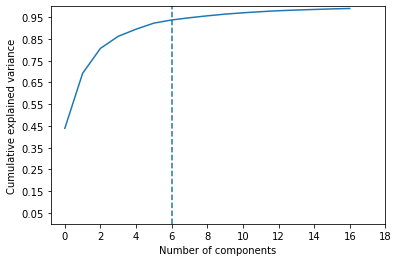

In [44]:
pca=PCA(n_components=.99,svd_solver="full")
pca.fit(data45_nom)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.yticks(np.arange(0.05,1.1,step=.1))
plt.xticks(np.arange(0,20,step=2))
plt.axvline(x=6,linestyle='--')
plt.ylim(0,1)
plt.savefig("pca.jpg")

In [54]:
data_pca.shape

(1046826, 6)

In [52]:
data45_nom.shape

(1046826, 45)

We decide to keep the top 6 principal components and recalculate PCA

In [35]:
pca=PCA(n_components=6)
princ_comps=pca.fit_transform(data45_nom)
data_pca=pd.DataFrame(princ_comps,columns=['PC'+str(i) for i in range(1,pca.n_components_+1)])
data_pca.shape

(1046826, 6)

Z scale the PC's

In [36]:
pca_mean=data_pca.mean()
pca_sd=data_pca.std()
data_pca=(data_pca-pca_mean)/pca_sd
data_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06,1.046826e+06
mean,-1.344949e-16,2.775073e-15,-7.680978e-16,2.589567e-15,-3.892716e-15,1.232812e-15
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.585169e-01,-2.280285e+02,-1.990058e+02,-2.023902e+02,-2.438866e+02,-2.002481e+02
25%,-1.088008e-01,-1.544611e-01,-1.356178e-01,-3.269407e-02,-1.159060e-01,-1.101848e-01
50%,-2.375699e-02,-5.919442e-02,6.965017e-04,1.366906e-02,-1.313763e-02,-2.535340e-02
75%,3.290240e-02,3.225958e-02,3.206016e-01,7.018394e-02,4.879357e-02,1.382280e-01
max,6.907817e+02,3.239819e+02,5.967327e+02,2.507934e+02,4.068853e+02,4.017191e+02


In [37]:
pc_summary=data_pca.describe()

In [38]:
pc_summary.round(2)

,PC1,PC2,PC3,PC4,PC5,PC6
count,1046826.00,1046826.00,1046826.00,1046826.00,1046826.00,1046826.00
mean,-0.00,0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00
min,-0.26,-228.03,-199.01,-202.39,-243.89,-200.25
25%,-0.11,-0.15,-0.14,-0.03,-0.12,-0.11
50%,-0.02,-0.06,0.00,0.01,-0.01,-0.03
75%,0.03,0.03,0.32,0.07,0.05,0.14
max,690.78,323.98,596.73,250.79,406.89,401.72


In [106]:
data_pca[data_pca.index==39769]

,PC1,PC2,PC3,PC4,PC5,PC6
39769,-0.239557,-0.22931,0.399528,0.023825,0.071283,0.138076


In [104]:
data[data.ZIP==10451][["FULLVAL","AVLAND"]].mean()

FULLVAL    2.651731e+06
AVLAND     1.392748e+05
dtype: float64

In [108]:
data[data.index==39769].T

,39769
RECORD,39770
BBLE,1007980066
B,1
BLOCK,798
LOT,66
EASEMENT,NaN
OWNER,GREENHORN DEVELOPMENT
BLDGCL,D9
TAXCLASS,2
LTFRONT,75


In [85]:
from numpy import dot
from numpy.linalg import norm

def explain(n):
    def cos_sim(a,b):
        return dot(a, b)/(norm(a)*norm(b))
    l=[]
    for i in range(data45_nom.shape[1]):
        l.append(cos_sim(data_pca.iloc[:,n],data45_nom.iloc[:,i]))
    return pd.DataFrame([l,data45_nom.columns]).T.sort_values(by=0,ascending=False)

In [99]:
explain(2)

,0,1
25,0.42592,r8_zip3
43,0.422784,r8_boro
40,0.344647,r5_boro
22,0.340383,r5_zip3
7,0.335936,r8
26,0.29328,r9_zip3
8,0.290779,r9
4,0.281657,r5
44,0.281491,r9_boro
15,0.273362,r7_zip5


### 4.3 Fraud scores

#### 4.3.1 Z score outliers

In [36]:
p=2
one_over_p=1/p
score1=((data_pca).abs()**p).sum(axis=1)**one_over_p

(0.1, 2088582.7348885664)

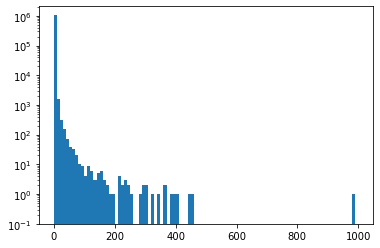

In [42]:
plt.hist(score1,bins=100,range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

#### 4.3.2 Autoencoder error

In [38]:
from keras.models import Model
from keras.layers import Input, Dense

In [41]:
#placeholder for input
data_in=Input(shape=(6,))

#dimension of the encoded data. Choose 3
encoded_dim=3

#encoded representation of the data
encoded=Dense(encoded_dim,activation='tanh')(data_in)

#reconstruction of the input
decoded=Dense(6,activation='tanh')(encoded)

#this model maps the input data to the reconstructed data
autoencoder=Model(data_in,decoded)

autoencoder.compile(optimizer='adam',loss='mean_squared_error')

autoencoder.fit(data_pca,data_pca, epochs=3, shuffle=True, validation_data=(data_pca,data_pca))

pca_out=autoencoder.predict(data_pca)
error=pca_out-data_pca
p=2
oop=1/p
score2=(error.abs()**p).sum(axis=1)**oop

Epoch 1/3
32714/32714 [==============================] - 27s 804us/step - loss: 1.1195 - val_loss: 0.8970
Epoch 2/3
32714/32714 [==============================] - 26s 791us/step - loss: 0.7725 - val_loss: 0.8952
Epoch 3/3
32714/32714 [==============================] - 26s 797us/step - loss: 0.9716 - val_loss: 0.8922


(0.1, 2090092.3664951806)

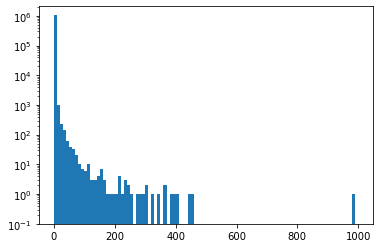

In [43]:
plt.hist(score2,bins=100,range=(0,1000))
plt.yscale('log')
plt.ylim(ymin=.1)

#### 4.3.3 Final score and ranking

In [44]:
scores=pd.DataFrame(score1)
scores.columns=["score1"]
scores["score2"]=score2
scores["score1_rank"]=scores['score1'].rank()
scores["score2_rank"]=scores["score2"].rank()
scores["final"]=(scores["score1_rank"]+scores["score2_rank"])/2
top_records=scores.sort_values(['final'],ascending=False).head(100)

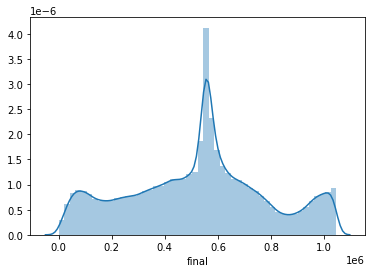

In [47]:
sns.distplot(scores["final"])

In [63]:
top_origin=property_data.loc[top_records.index,"index":'VALTYPE']

In [90]:
final_output=pd.concat([top_origin,top_records.loc[:,"score1_rank":"final"]],axis=1).set_index("index")
final_output.to_excel("final_output.xlsx")